In [4]:
from notebooks.utils import *

In [5]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

In [8]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [9]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence', 'MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [10]:
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= 5 else 0)

In [11]:
shannon_entropy = pd.read_csv("data/pfeature/ha_avp_ic50_shannon_entropy.csv")
shannon_entropy = shannon_entropy.drop(['ID', 'Sequence'], axis=1)
residue_repeats = pd.read_csv("data/pfeature/ha_avp_ic50_residue_repeat.csv")
residue_repeats = residue_repeats.drop(['ID', 'Sequence'], axis=1).reset_index(drop=True)
sec_struct = pd.read_csv("data/pfeature/ha_avp_ic50_sec_struct.csv")
sec_struct = sec_struct.drop(['ID'], axis=1)

In [13]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [14]:
params = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [15]:
prop = []
for seq in df.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop.append([molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop = pd.DataFrame(prop, columns=params)

In [17]:
physicochem_prop = pd.concat([prop, shannon_entropy, residue_repeats, sec_struct], axis=1)

In [50]:
seq_len = df['Sequence'].map(lambda s: len(s))

In [51]:
np.corrcoef(seq_len, df['MIC'])

array([[ 1.        , -0.27406559],
       [-0.27406559,  1.        ]])

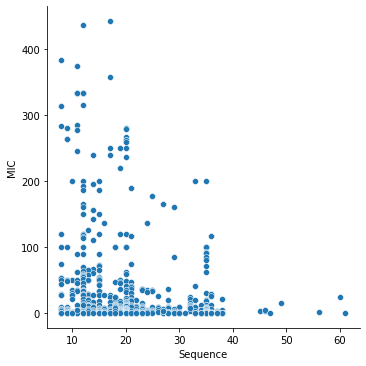

In [53]:
sns.relplot(x=seq_len, y=df['MIC'])

In [58]:
df2 = df[df['MIC']<1]

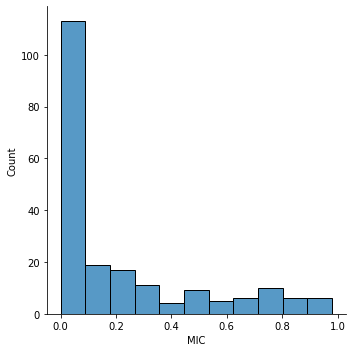

In [59]:
sns.displot(x=df2['MIC'])

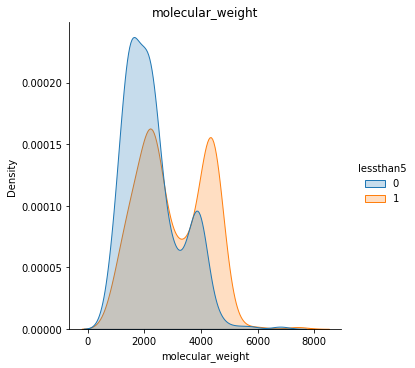

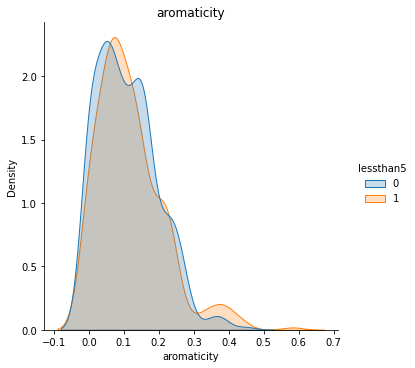

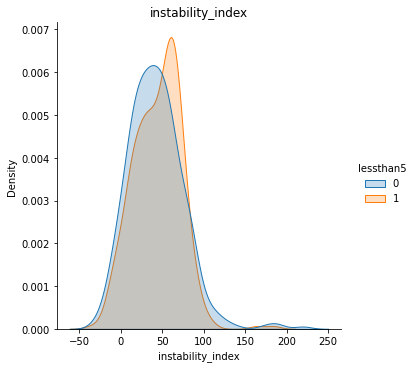

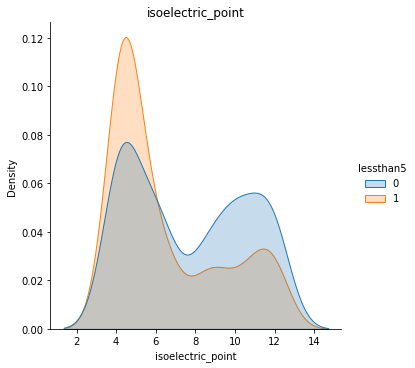

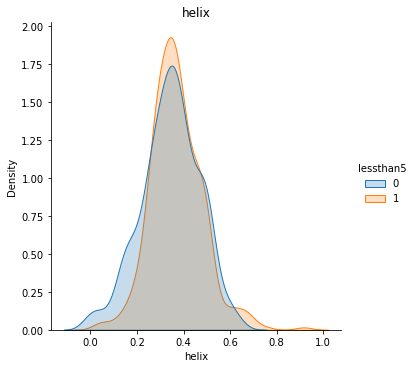

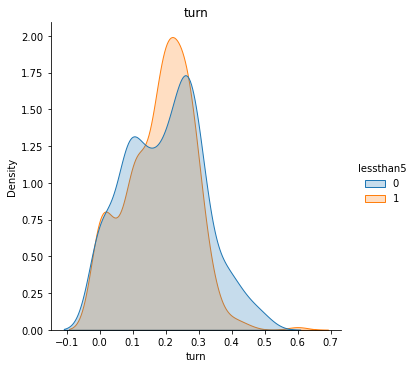

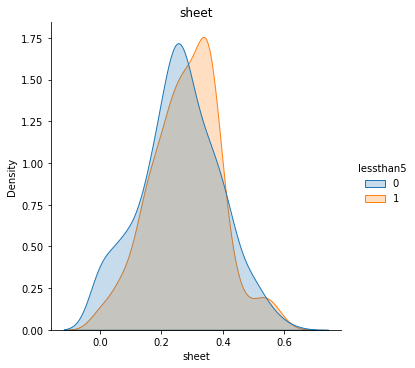

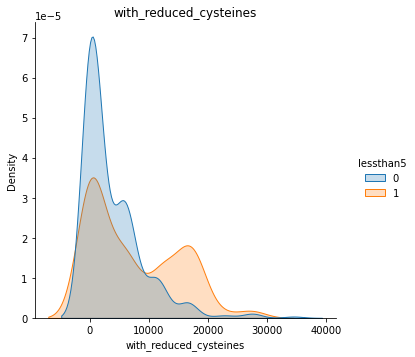

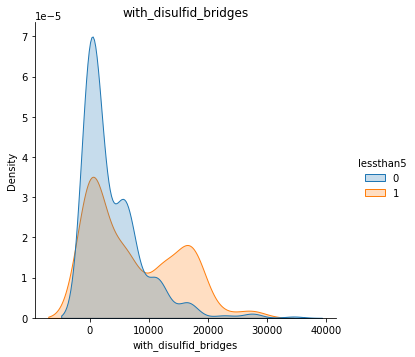

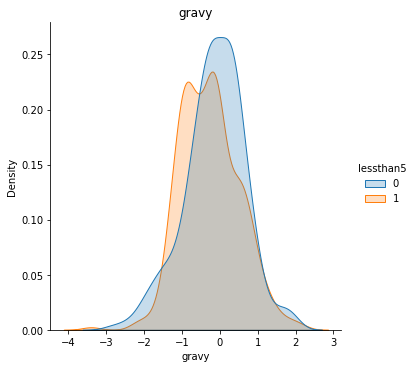

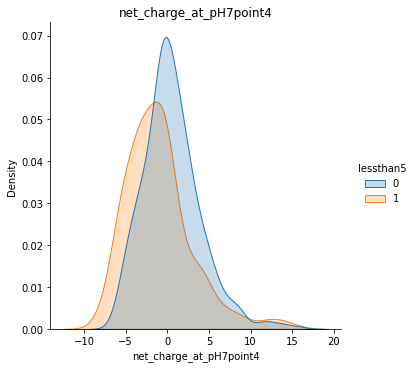

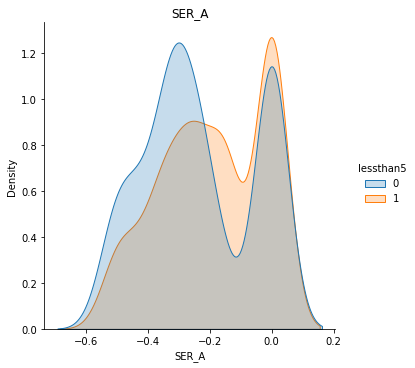

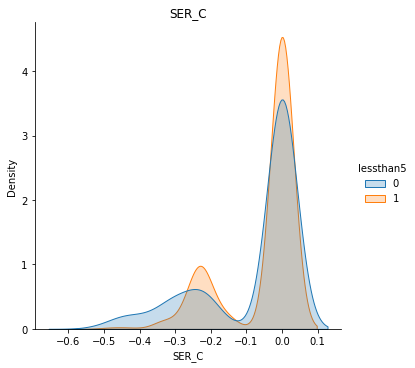

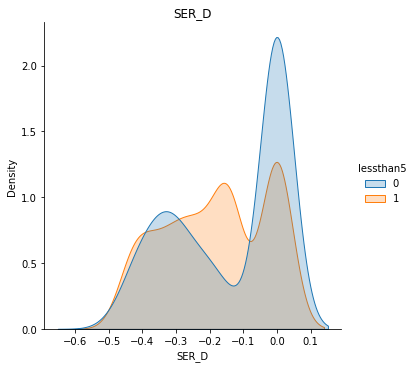

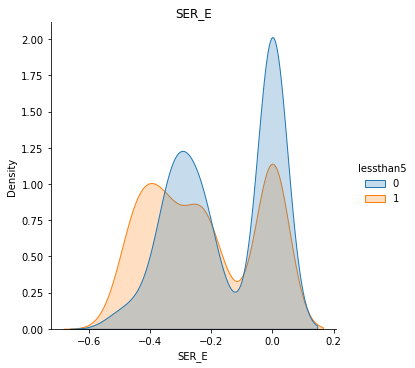

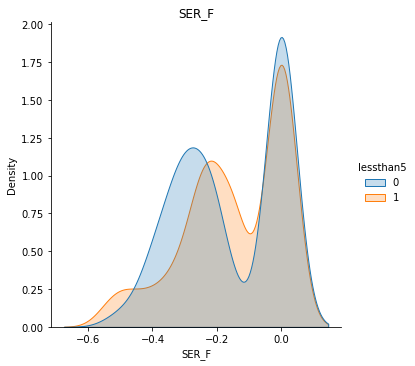

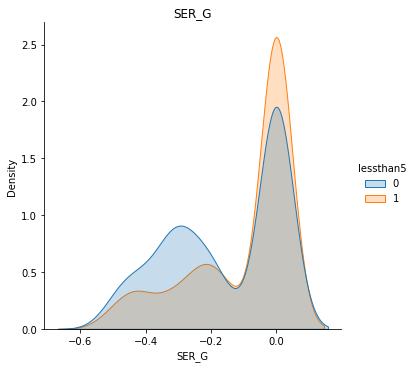

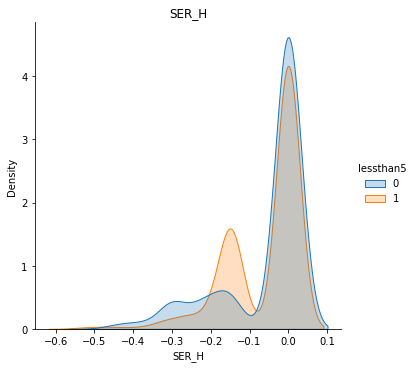

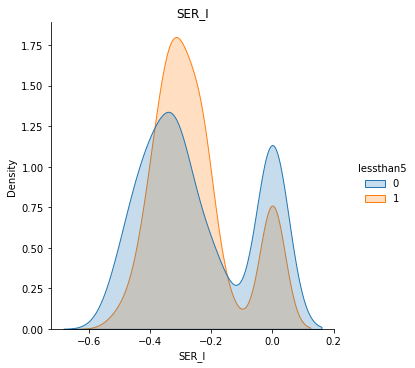

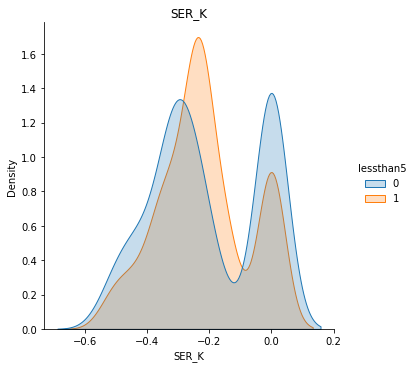

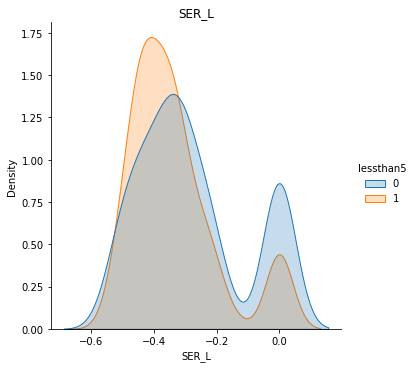

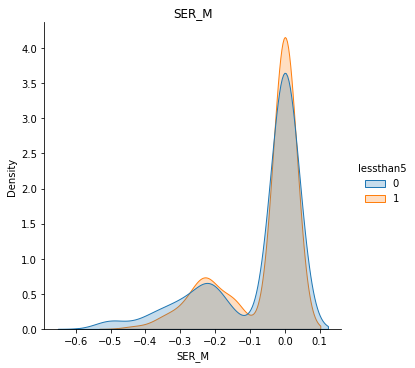

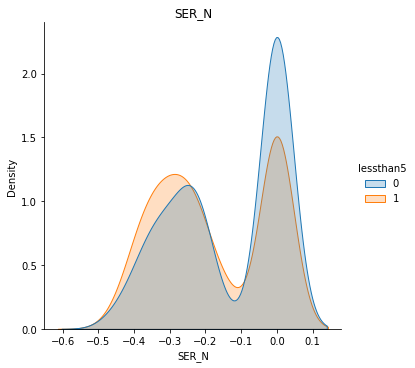

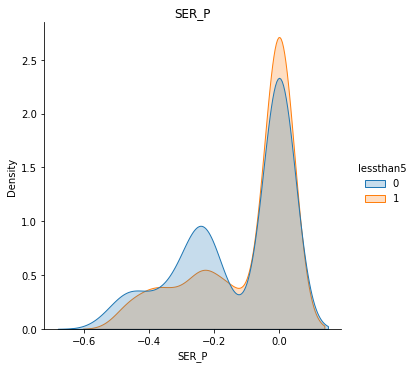

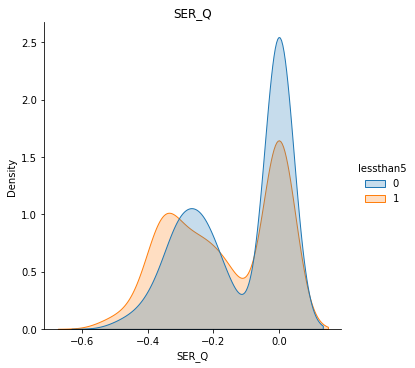

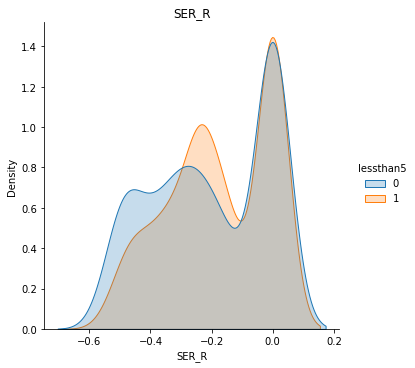

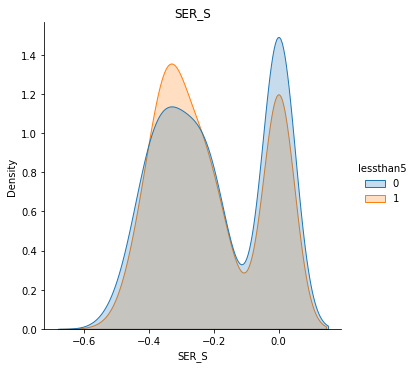

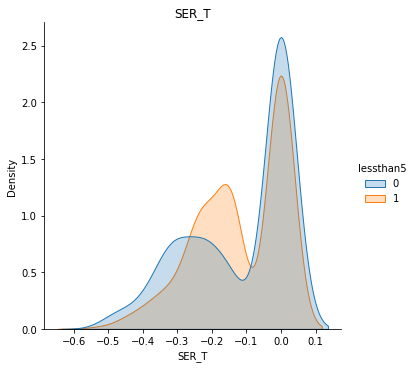

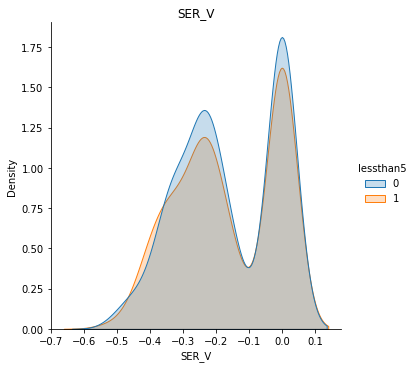

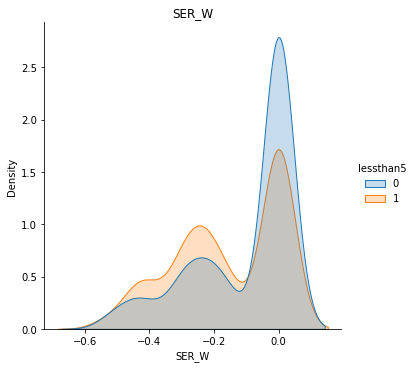

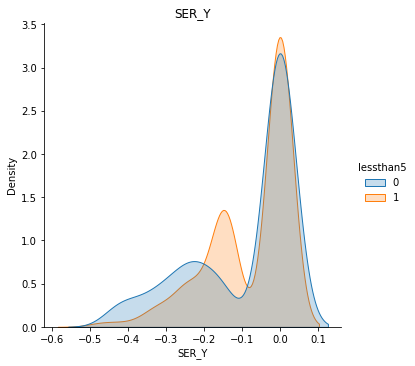

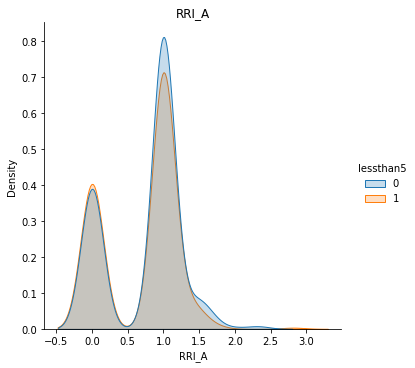

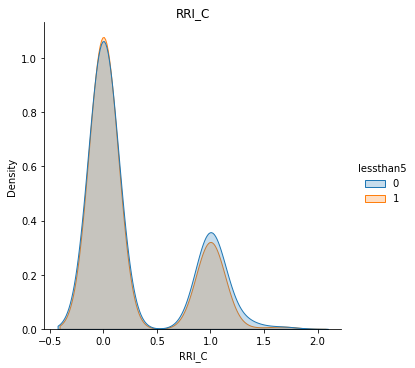

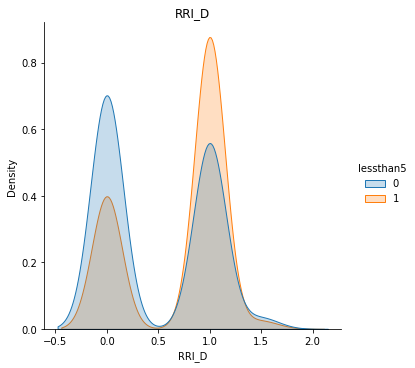

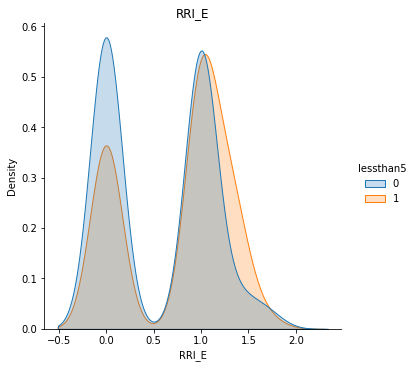

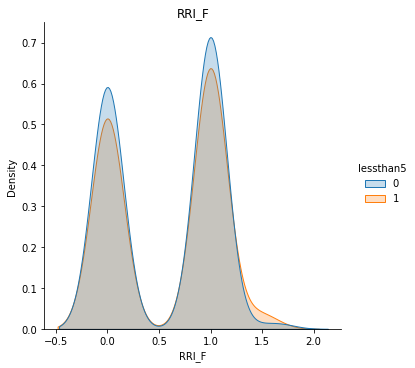

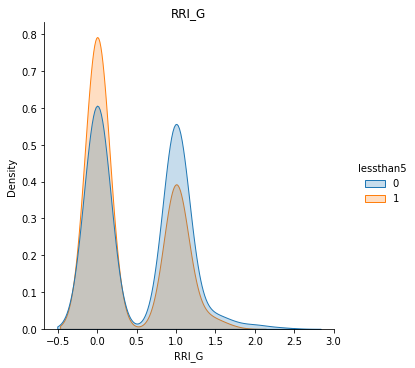

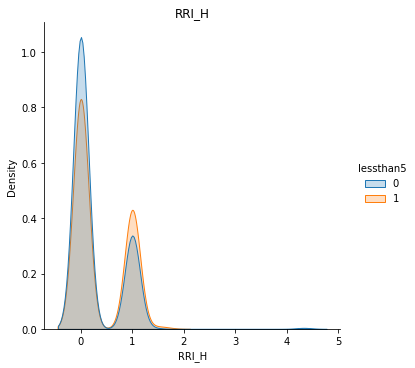

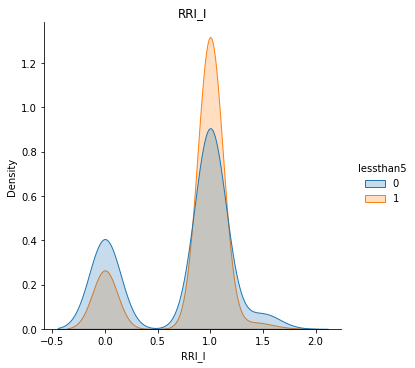

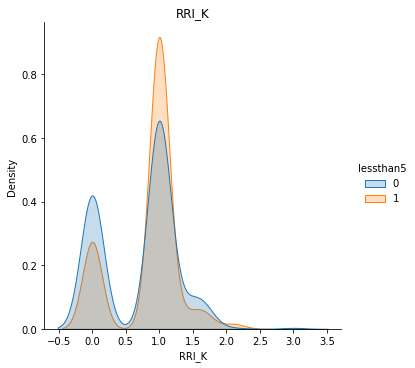

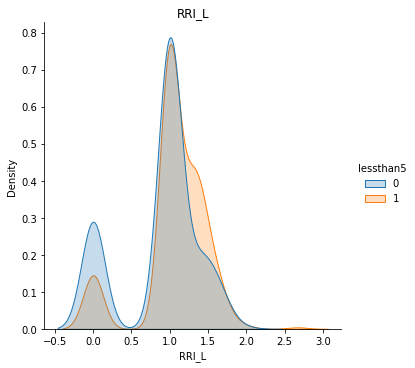

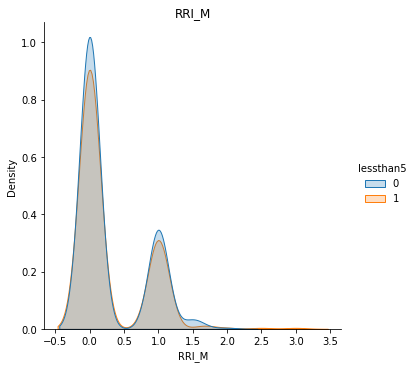

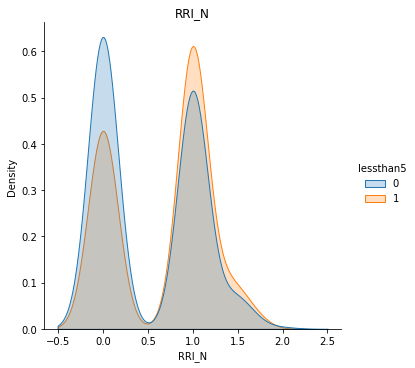

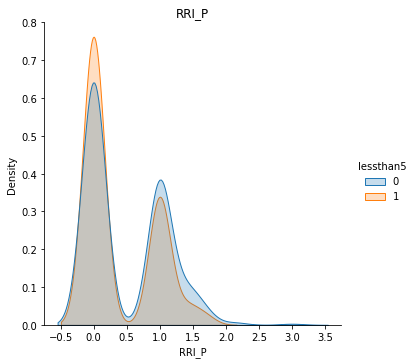

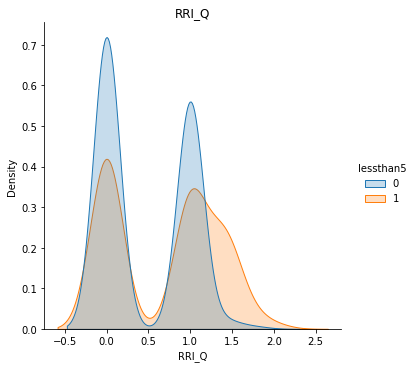

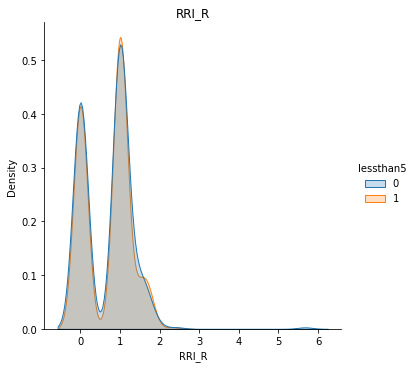

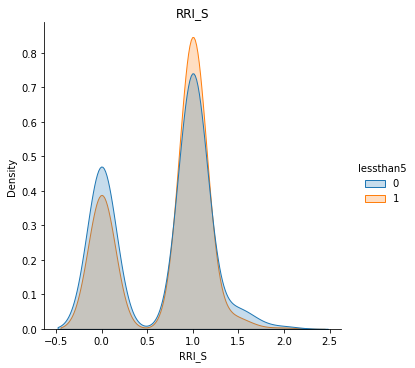

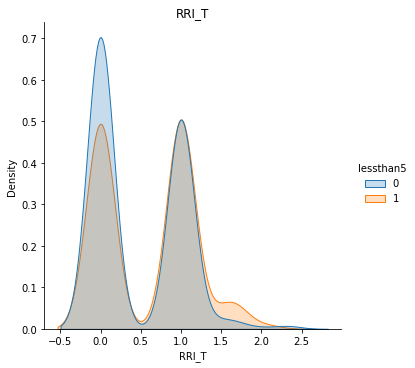

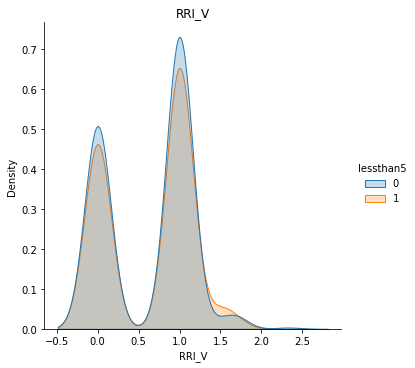

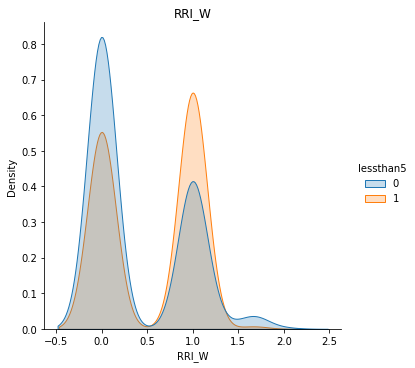

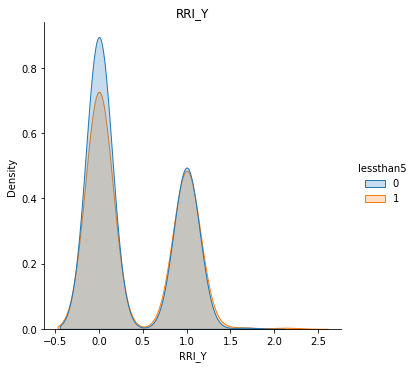

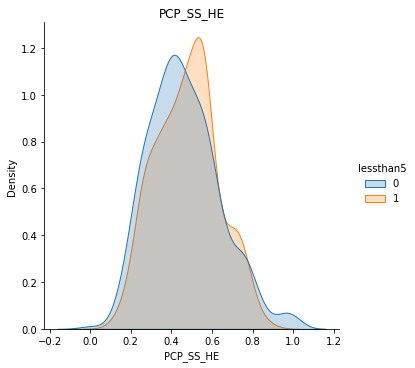

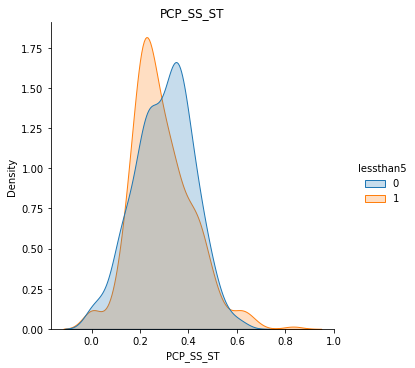

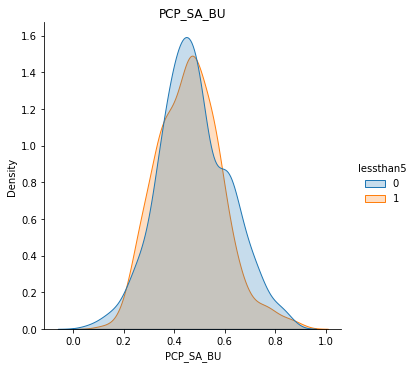

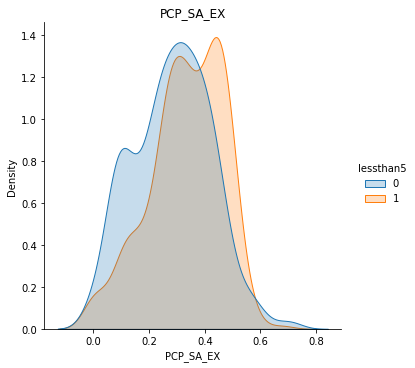

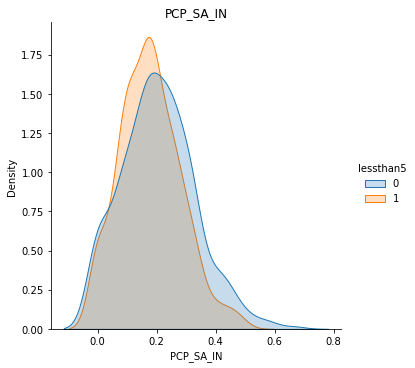

In [23]:
for feature in physicochem_prop.columns:
    sns.displot(x=physicochem_prop[feature], hue=df['lessthan5'], kind="kde", fill=True)
    plt.title(feature)
    plt.show()

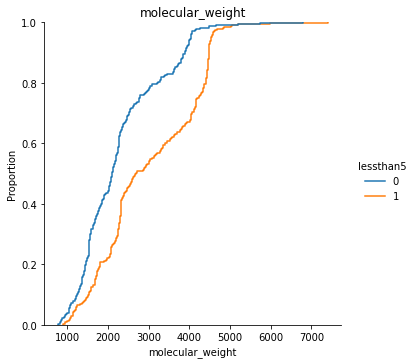

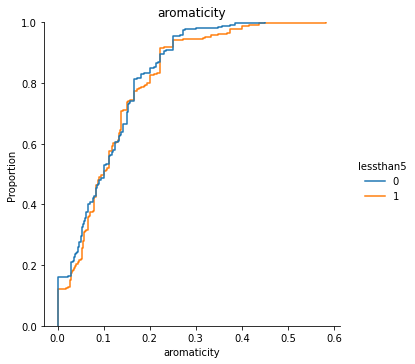

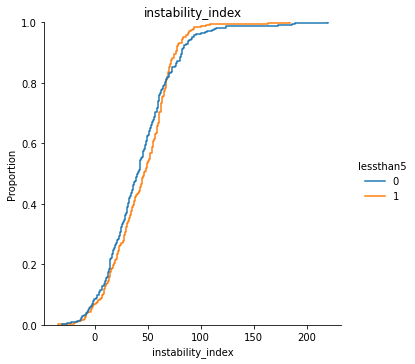

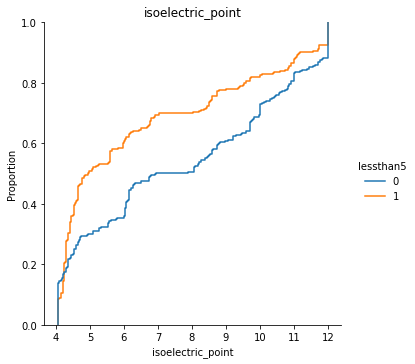

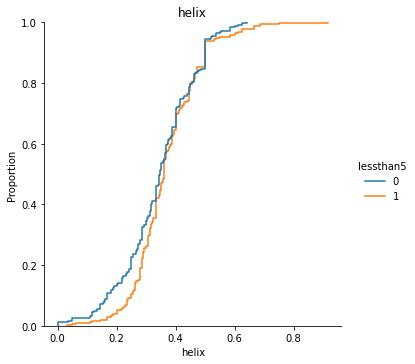

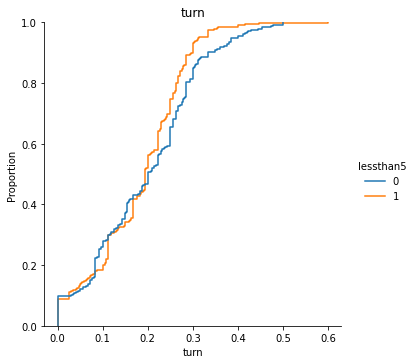

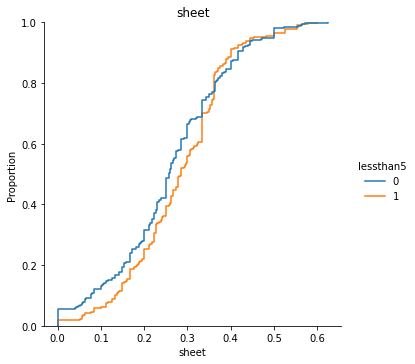

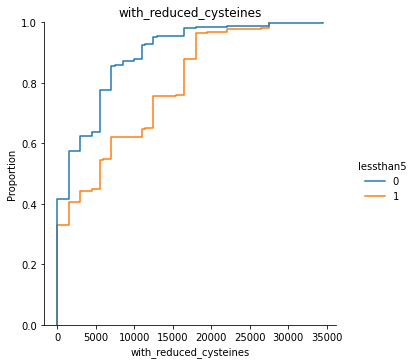

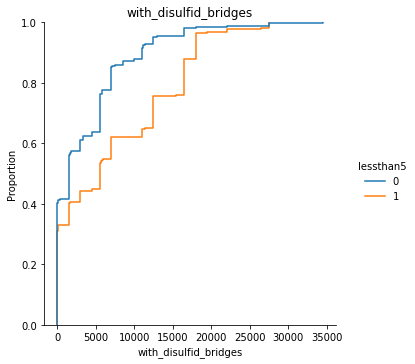

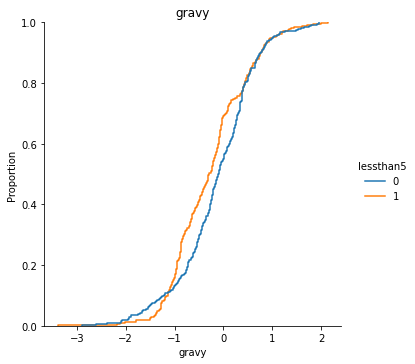

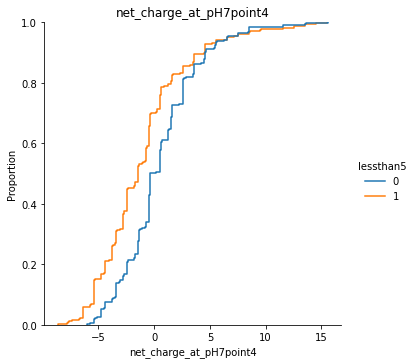

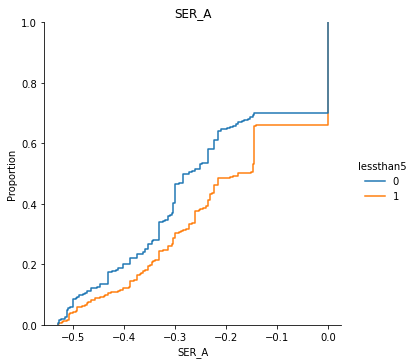

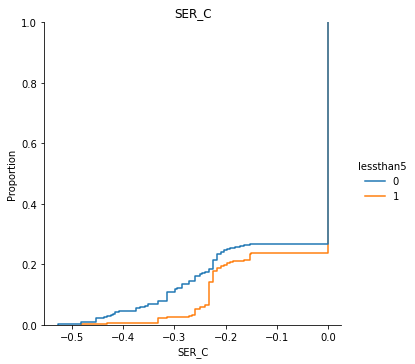

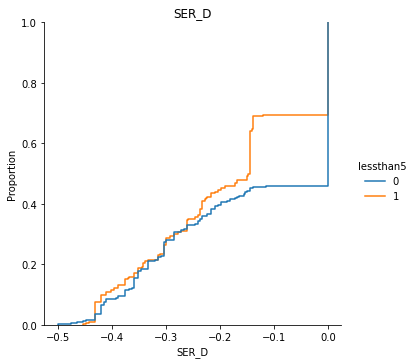

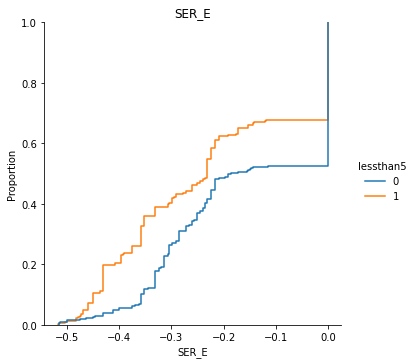

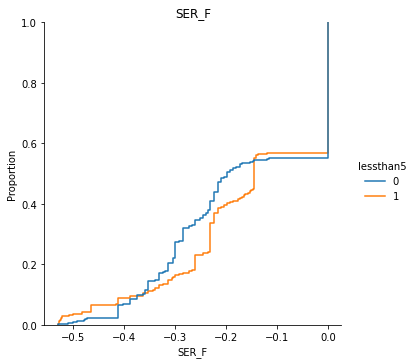

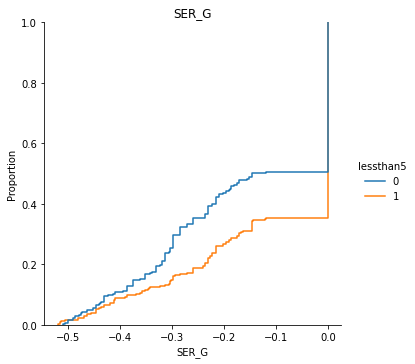

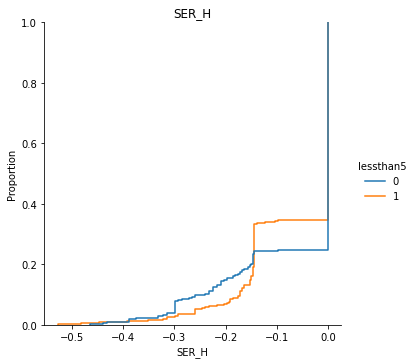

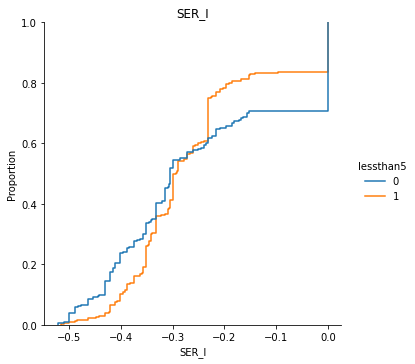

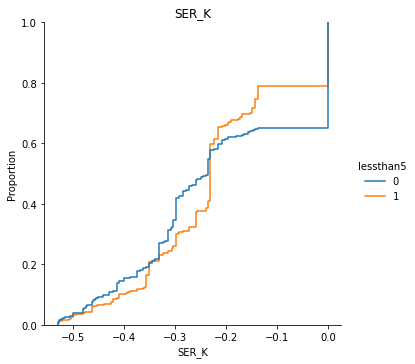

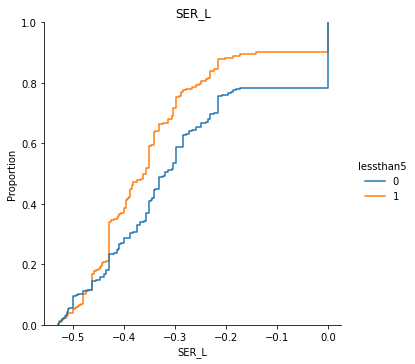

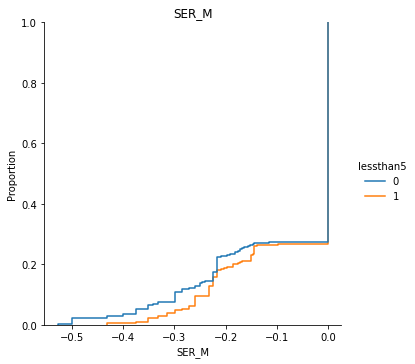

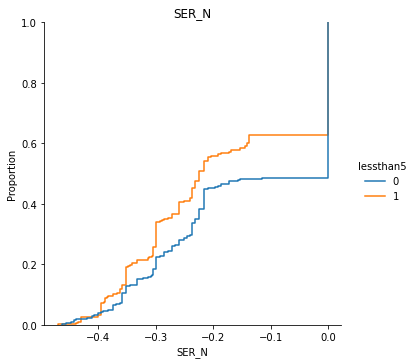

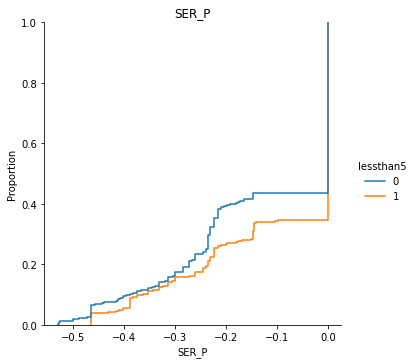

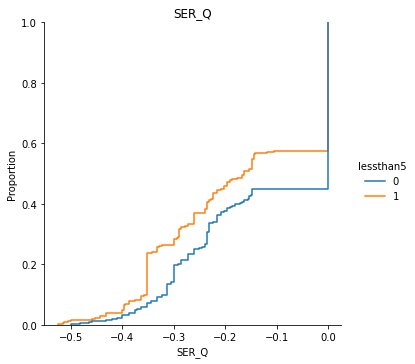

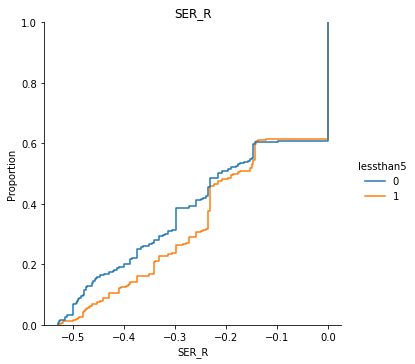

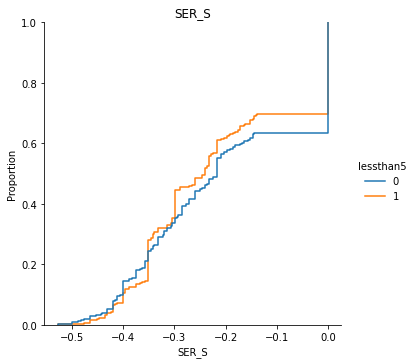

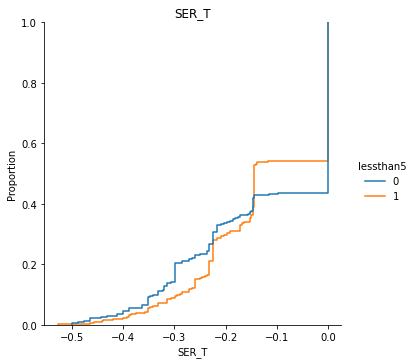

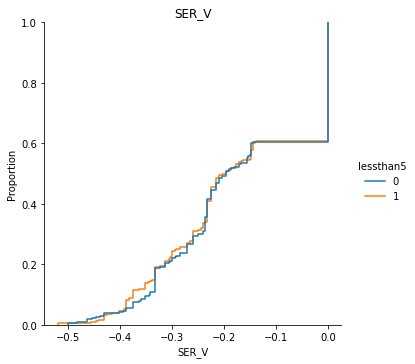

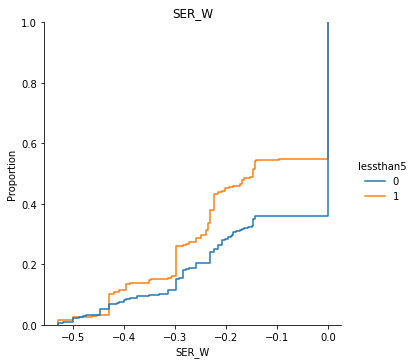

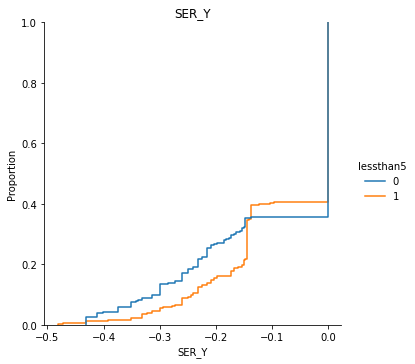

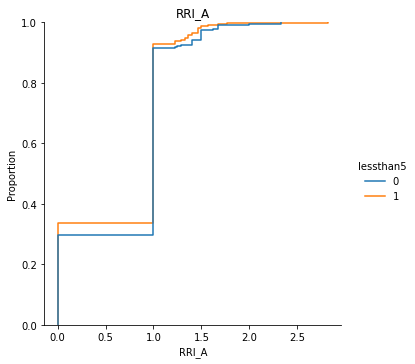

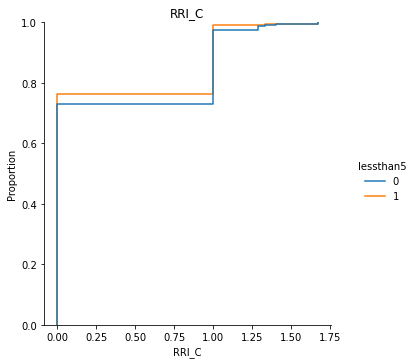

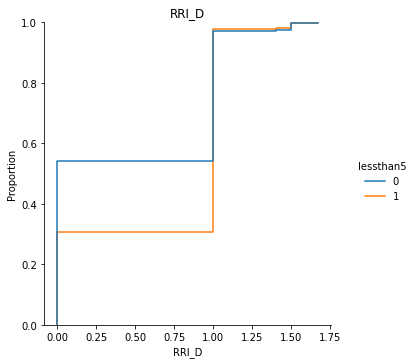

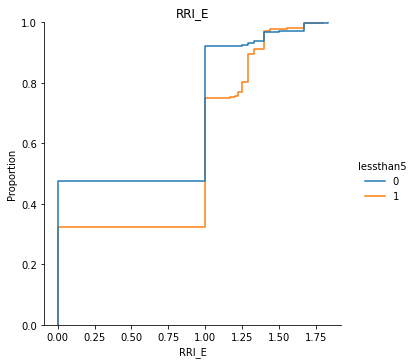

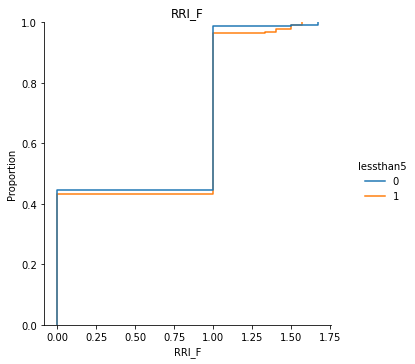

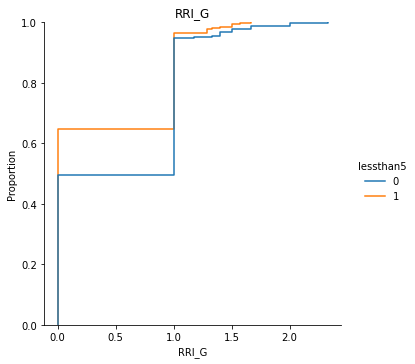

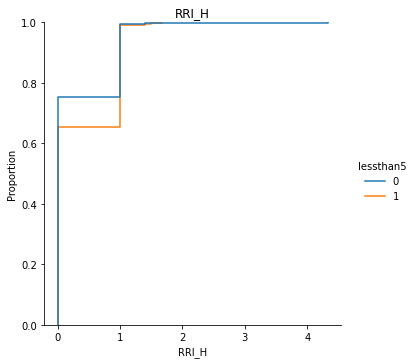

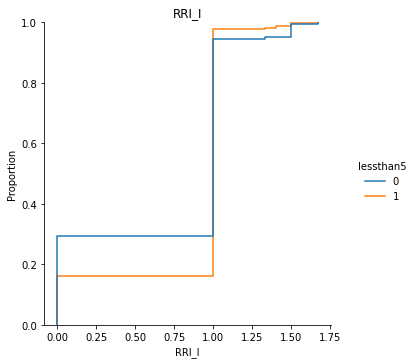

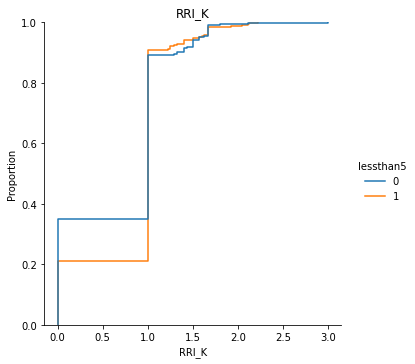

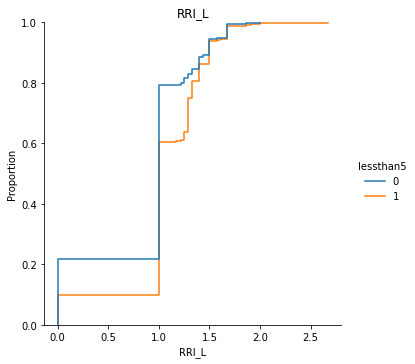

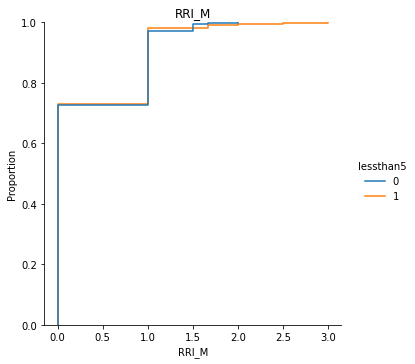

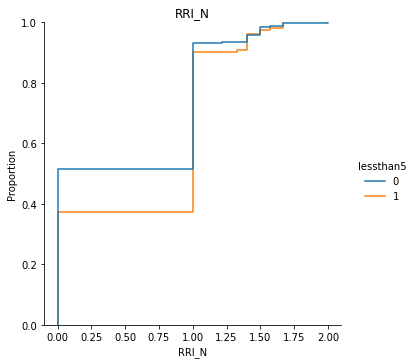

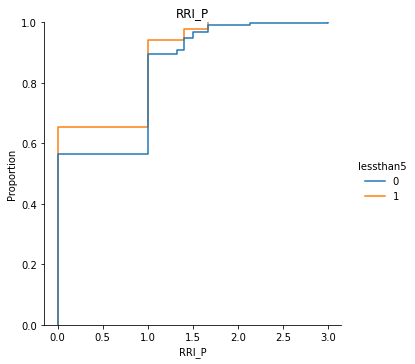

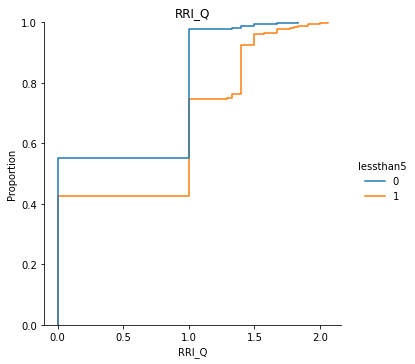

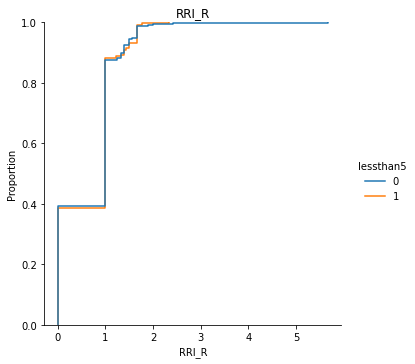

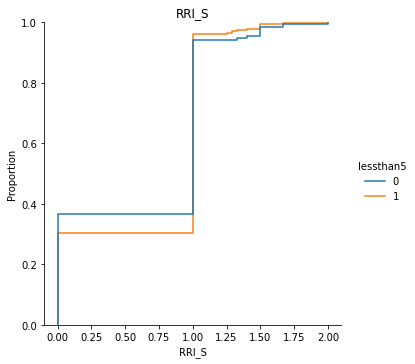

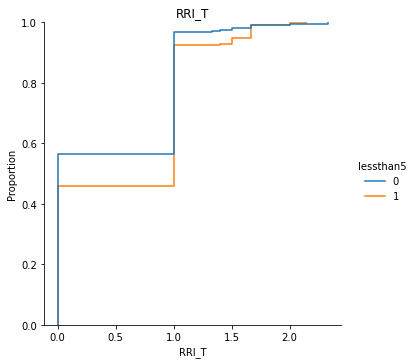

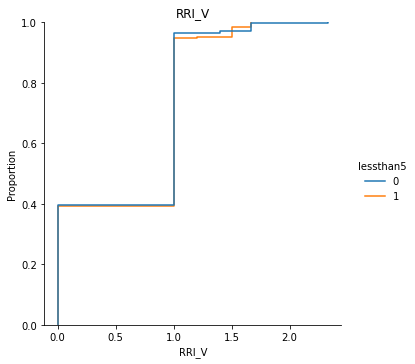

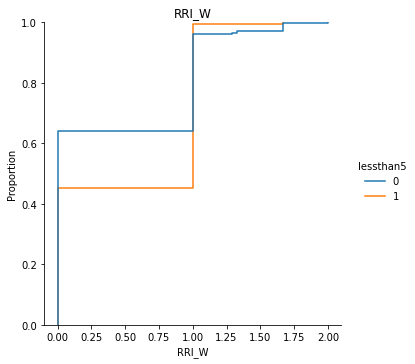

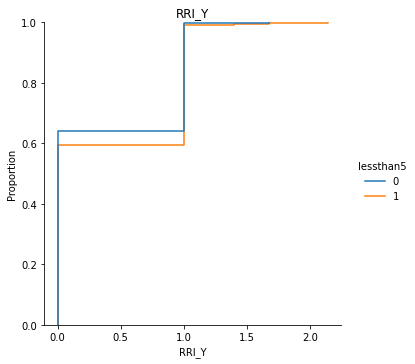

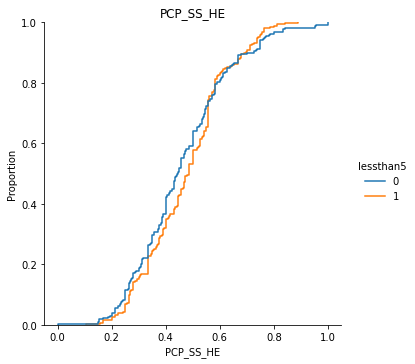

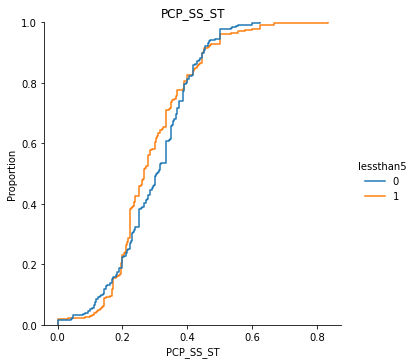

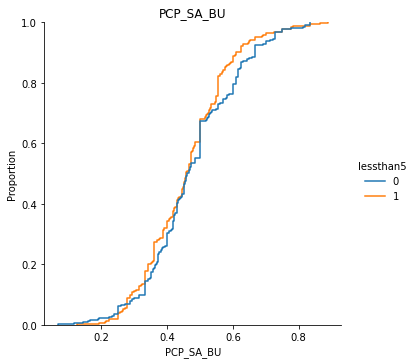

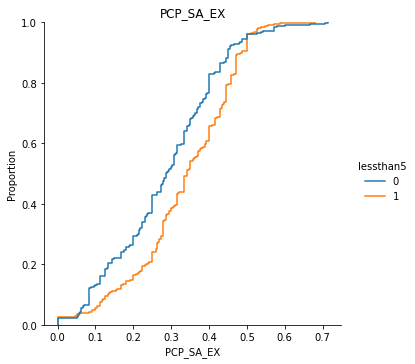

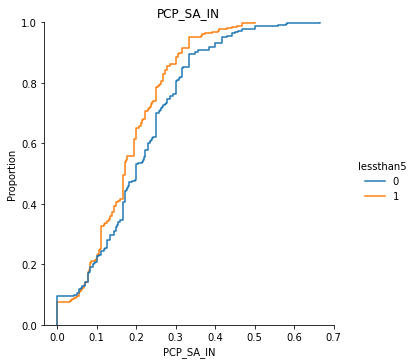

In [43]:
for feature in physicochem_prop.columns:
    sns.displot(x=physicochem_prop[feature], hue=df['lessthan5'], kind="ecdf")
    plt.title(feature)
    plt.show()

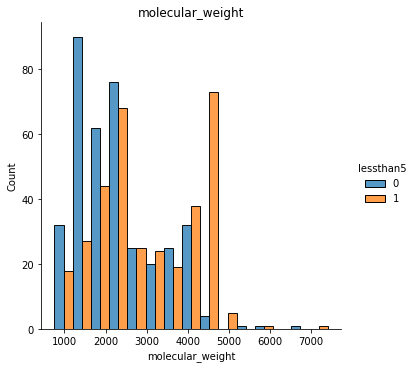

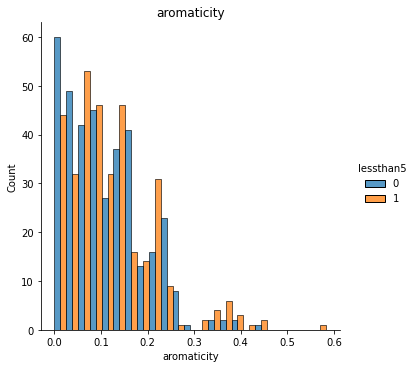

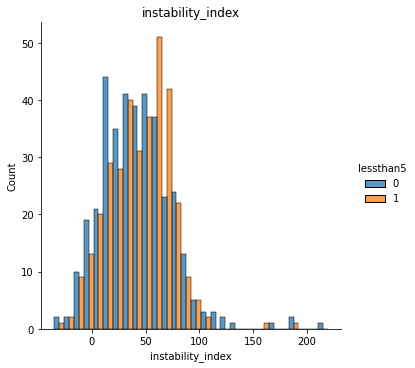

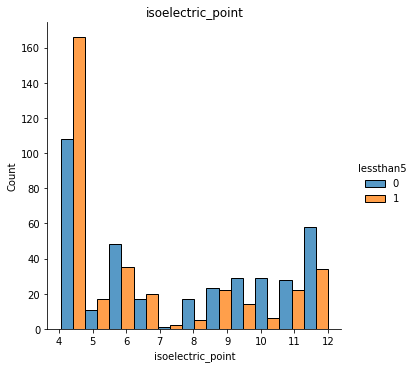

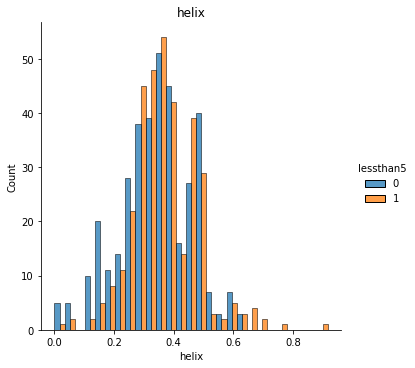

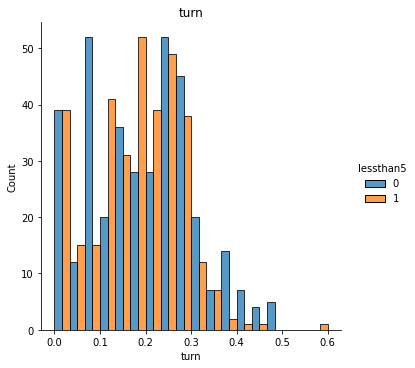

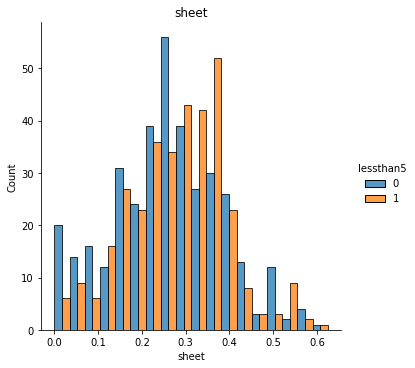

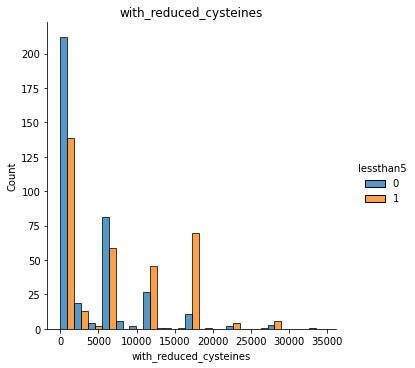

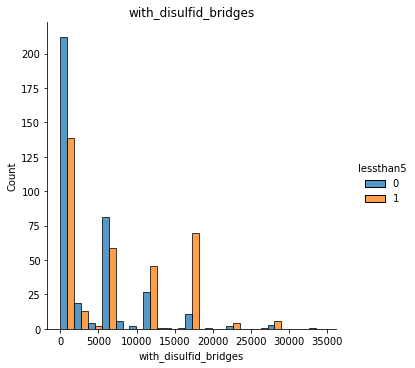

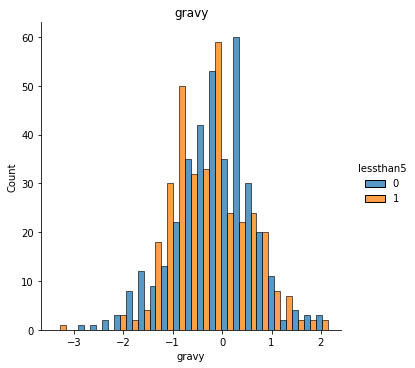

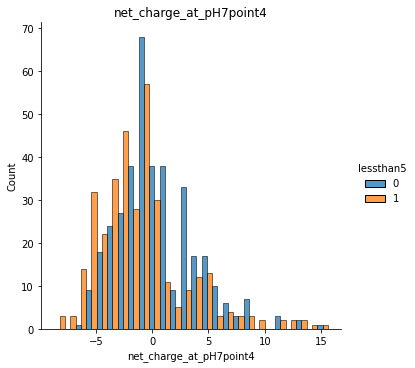

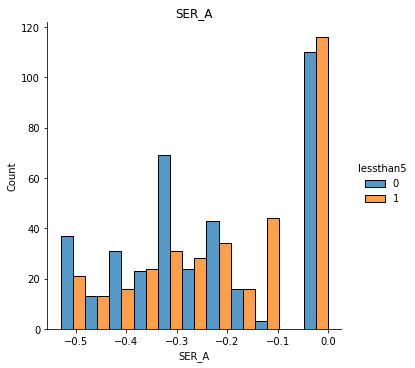

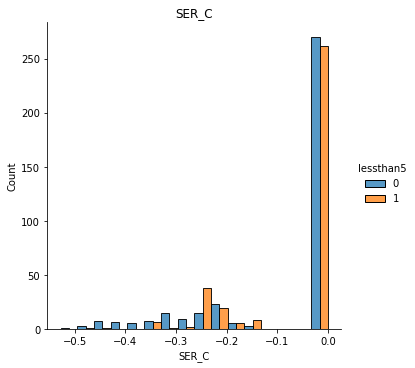

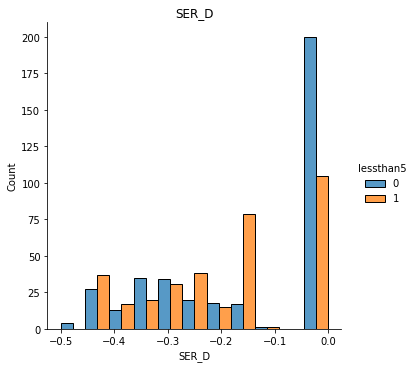

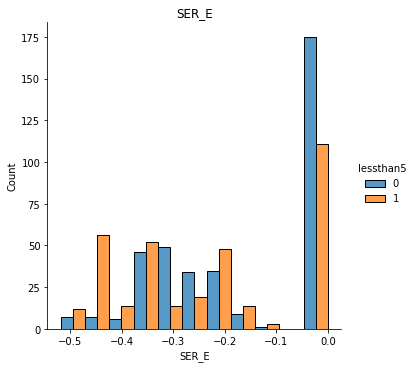

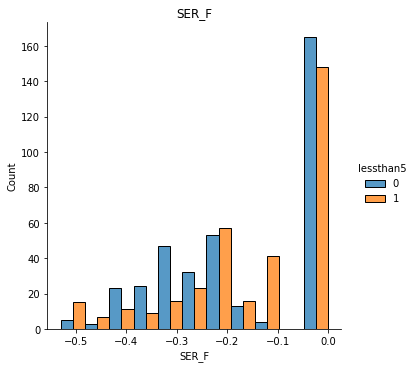

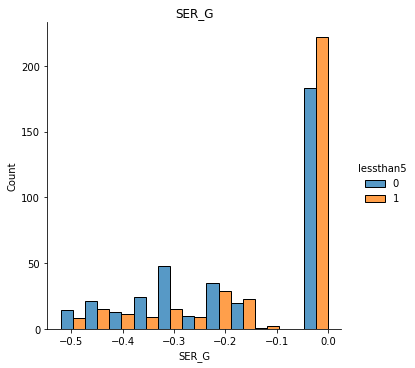

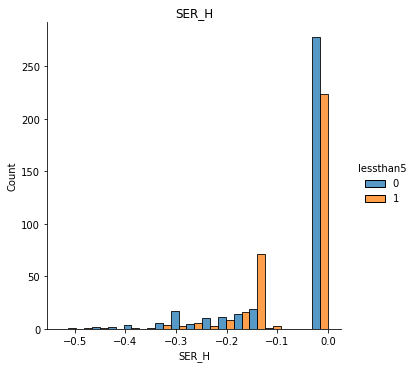

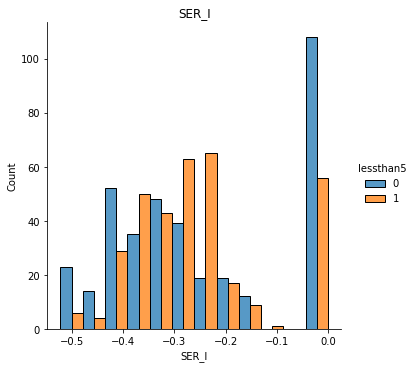

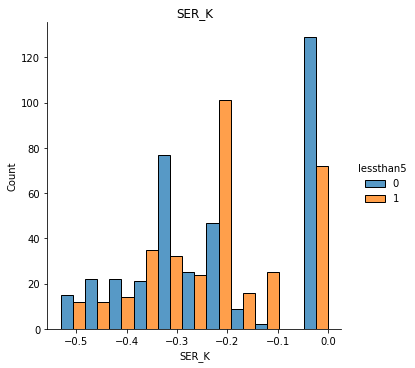

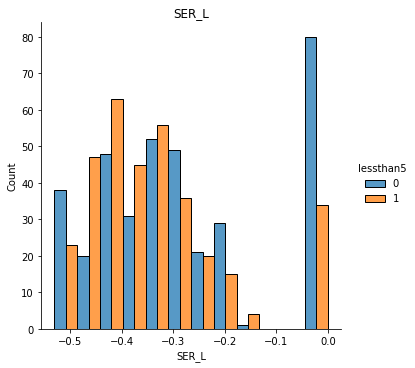

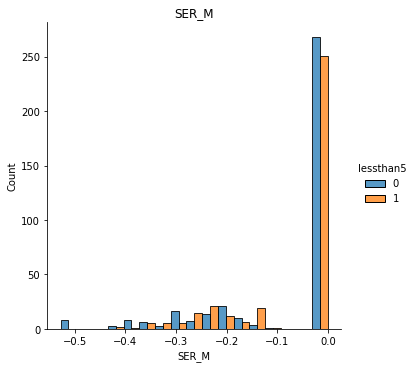

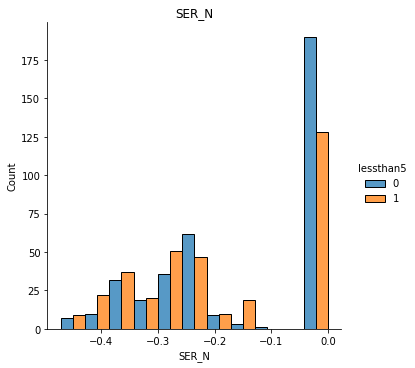

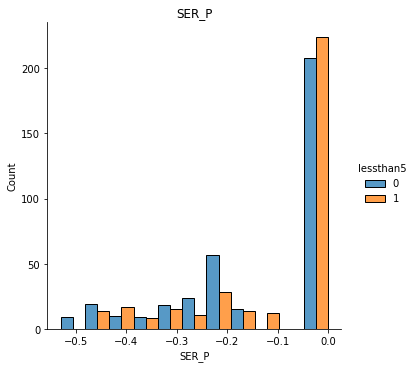

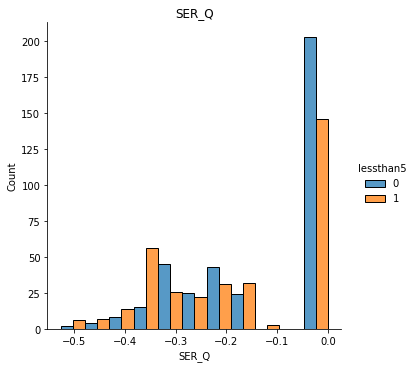

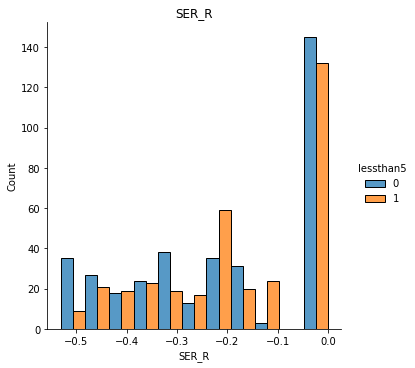

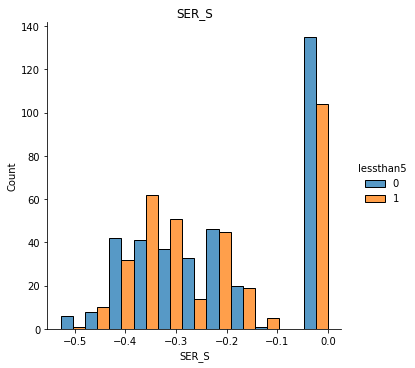

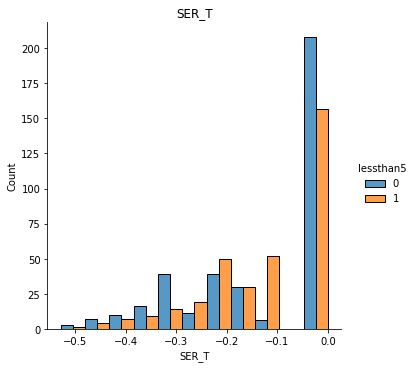

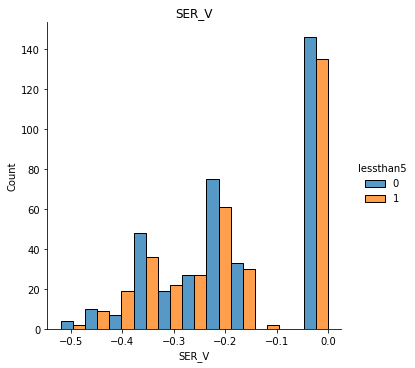

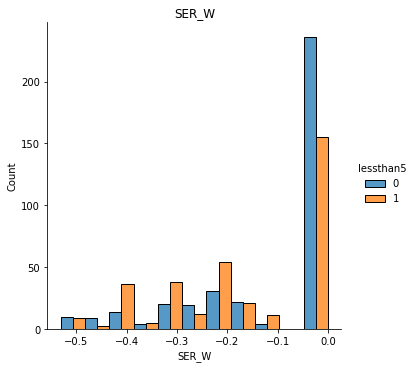

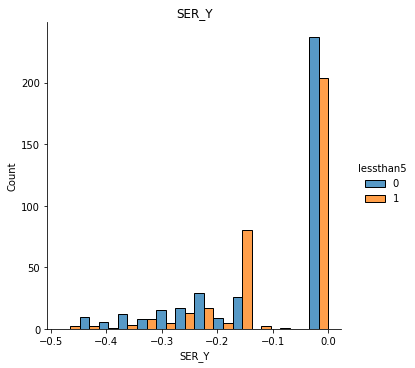

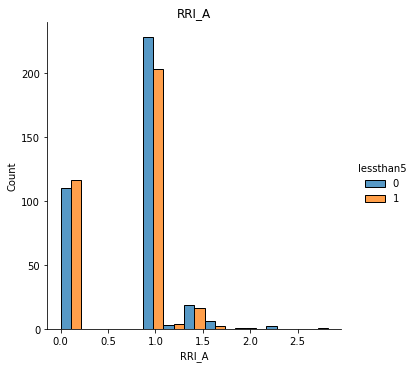

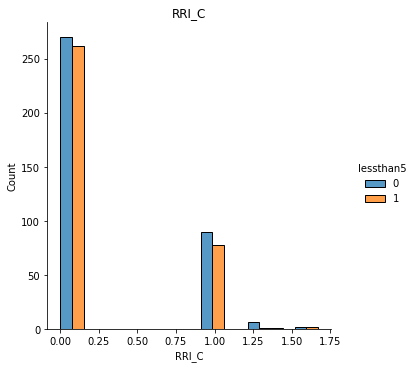

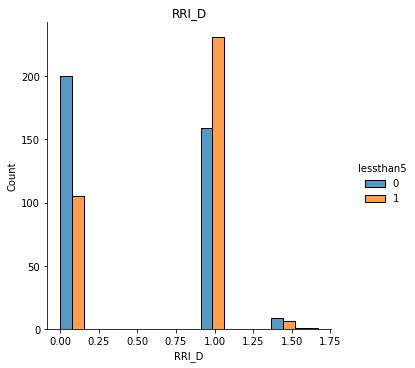

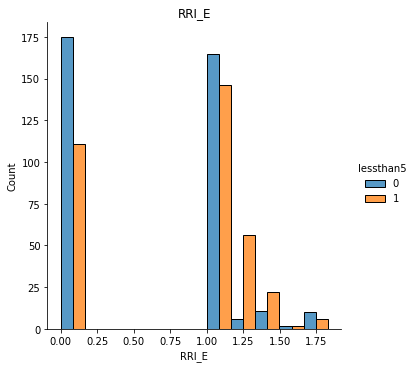

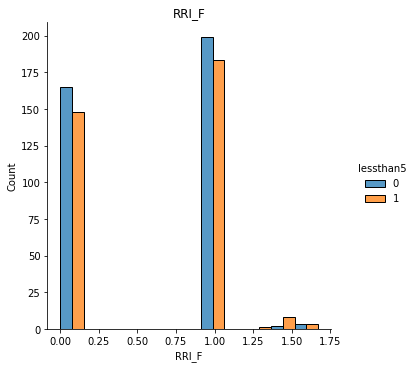

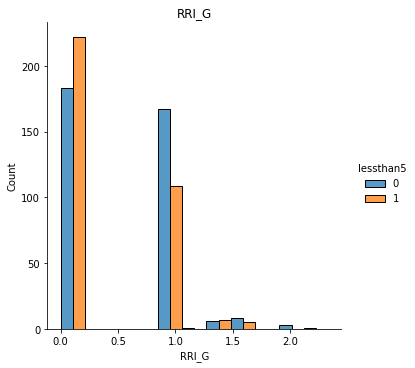

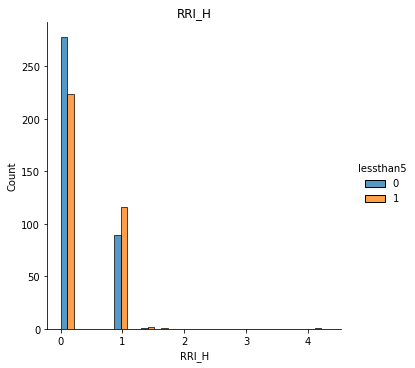

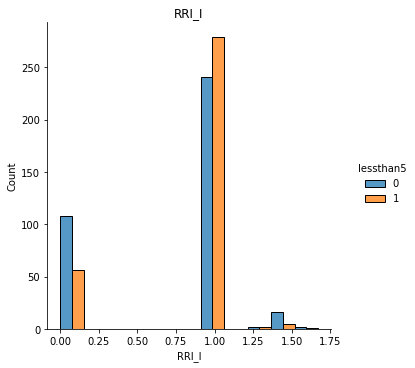

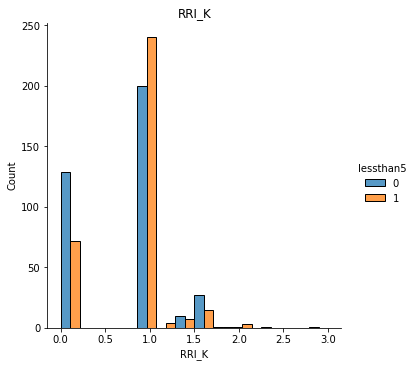

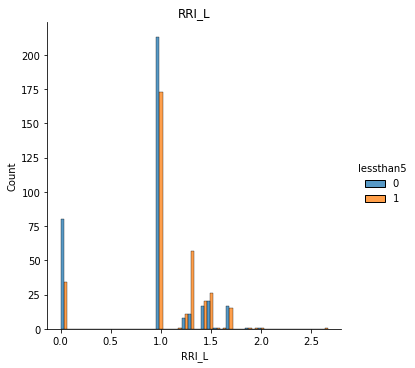

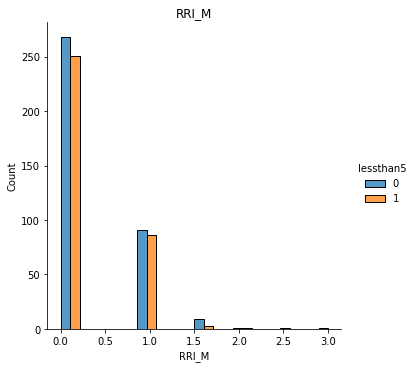

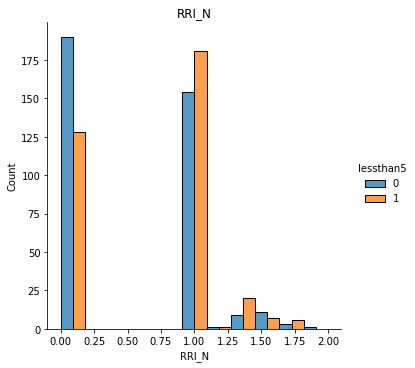

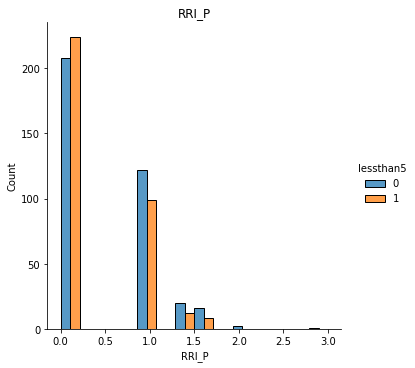

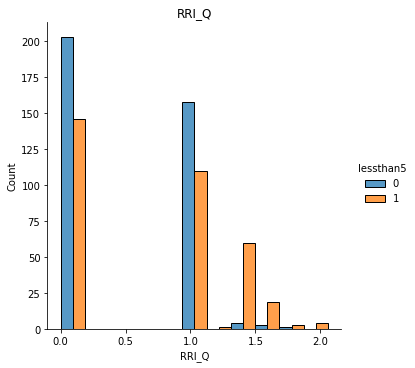

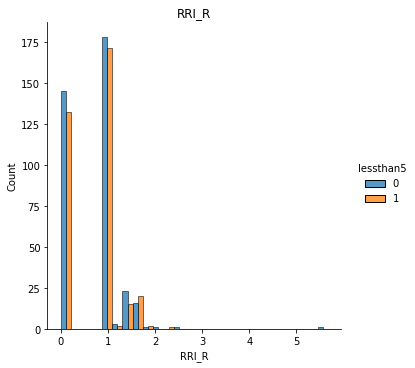

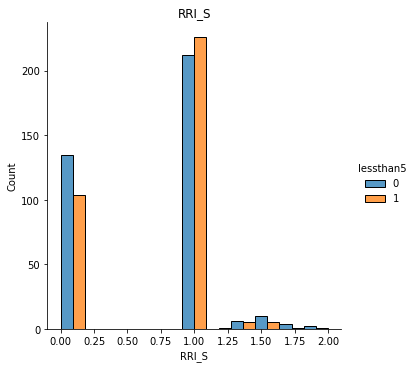

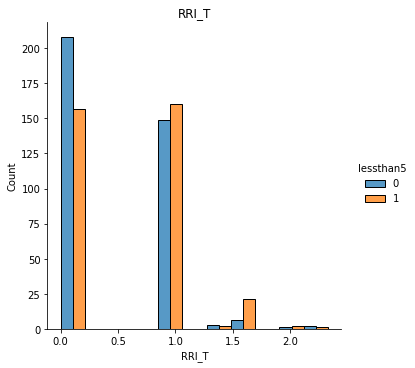

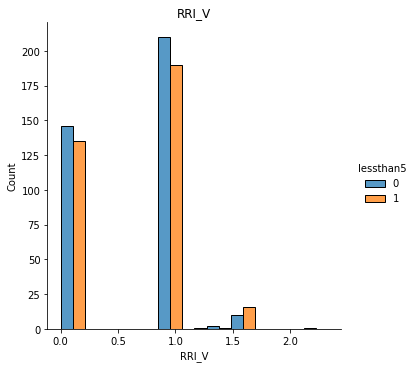

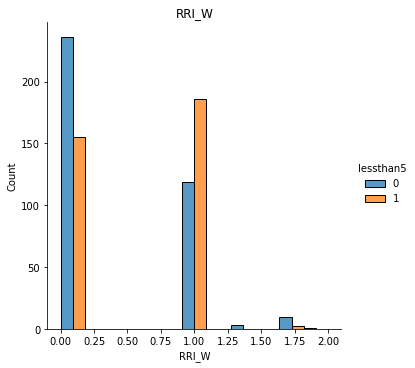

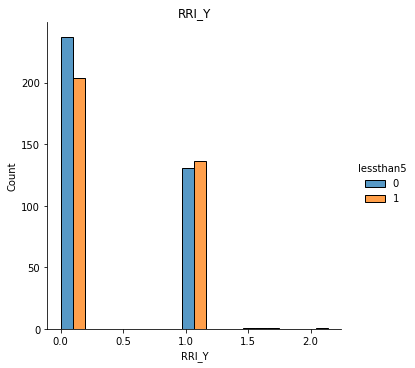

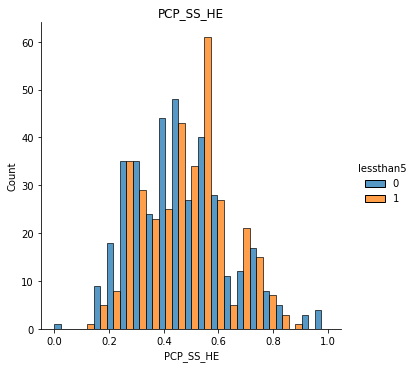

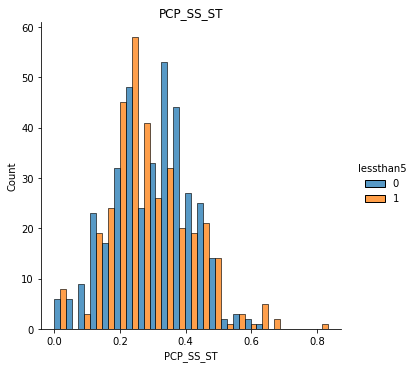

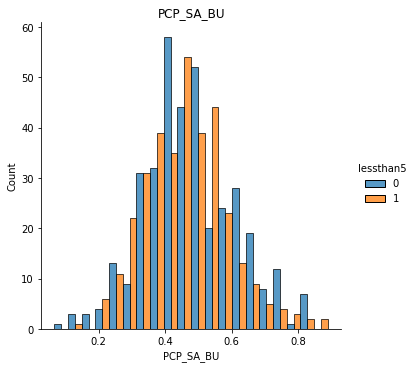

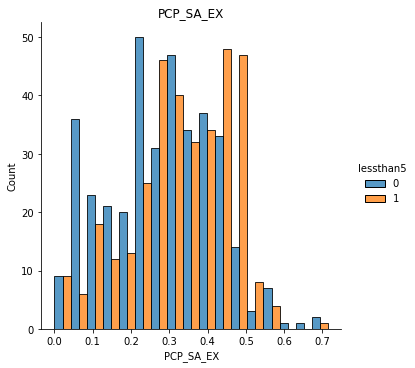

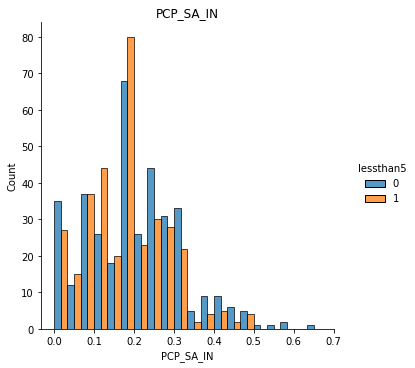

In [41]:
for feature in physicochem_prop.columns:
    sns.displot(x=physicochem_prop[feature], hue=df['lessthan5'], multiple="dodge")
    plt.title(feature)
    plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

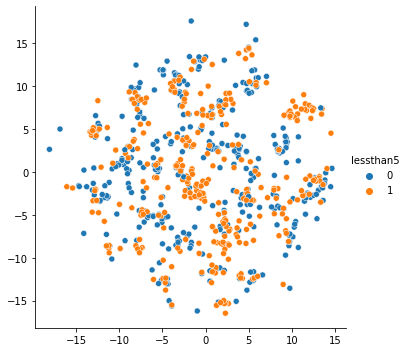

In [40]:
tsne = TSNE(perplexity=5, n_iter=250)
X = tsne.fit_transform(physicochem_prop)
sns.relplot(x=X[:,0], y=X[:,1], hue=df['lessthan5'])
plt.show()